In [1]:
import os, sys
import pandas as pd
import numpy as np
import random as rd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
import warnings
warnings.filterwarnings('ignore')

from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
cf.go_offline()
from pandas_profiling import ProfileReport

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder,MinMaxScaler,OneHotEncoder,StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_selection import RFE

from numpy import set_printoptions
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB



In [2]:
exps_dir = "../../exps"
if os.path.exists(exps_dir) == False: # tạo thư mục (nếu chưa có)
  os.makedirs(exps_dir, exist_ok=True)

save_dir = f"{exps_dir}/feature1"
os.makedirs(save_dir, exist_ok=True)
test_size=0.33
seed=42

* kiểm tra và tạo các thư mục (nếu chưa có)
* tập test 33%

# 5. Xây dựng và đánh giá mô hình học sâu Neutual Network

In [3]:
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.base import clone
from mlxtend.classifier import StackingClassifier
from kerastuner.tuners import RandomSearch
import numpy as np

In [4]:
x_train=pd.read_excel(f'{save_dir}/x_train.xlsx')
y_train=pd.read_excel(f'{save_dir}/y_train.xlsx')
x_test=pd.read_excel(f'{save_dir}/x_test.xlsx')
y_test=pd.read_excel(f'{save_dir}/y_test.xlsx')
class_weights_dict=dict(np.load(f'{exps_dir}/feature1/class_weights_dict.npz',allow_pickle=True))['class_weights_dict']
class_weights_dict = {key: value for key, value in class_weights_dict.item().items()}
class_weights_dict

{0: 1.0, 1: 1.0}

# Sử dụng RandomizedSearchCV để tinh chỉnh siêu tham số mô hình SVM

In [5]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from scipy.stats import uniform

# Định nghĩa không gian siêu tham số
param_dist = {'C': uniform(0.1, 10),
              'kernel': ['linear', 'rbf', 'poly'],
              'gamma': ['scale', 'auto'] + list(np.logspace(-3, 3, 7))}

# Khởi tạo mô hình SVM
svm_model = SVC()

# Sử dụng RandomizedSearchCV để tinh chỉnh siêu tham số
random_search = RandomizedSearchCV(svm_model, param_distributions=param_dist, n_iter=5, scoring='accuracy', cv=5)
random_search.fit(x_train, y_train)

# In ra thông tin của mô hình SVM tốt nhất
print("Best SVM Hyperparameters:")
print(random_search.best_params_)
C=random_search.best_params_['C']
gamma=random_search.best_params_['gamma']
kernel=random_search.best_params_['kernel']

Best SVM Hyperparameters:
{'C': 4.315723755771476, 'gamma': 'scale', 'kernel': 'rbf'}


In [6]:
from sklearn.ensemble import GradientBoostingClassifier
from scipy.stats import uniform, randint

# Định nghĩa không gian siêu tham số cho Gradient Boosting
param_dist_gb = {'n_estimators': randint(50, 200),
                 'learning_rate': uniform(0.01, 0.1),
                 'max_depth': randint(3, 10),
                 'subsample': uniform(0.6, 0.4)}

# Khởi tạo mô hình Gradient Boosting
gb_model = GradientBoostingClassifier()

# Sử dụng RandomizedSearchCV để tinh chỉnh siêu tham số
random_search_gb = RandomizedSearchCV(gb_model, param_distributions=param_dist_gb, n_iter=5, scoring='accuracy', cv=5)
random_search_gb.fit(x_train, y_train)

# In ra thông tin của mô hình Gradient Boosting tốt nhất
print("Best Gradient Boosting Hyperparameters:")
print(random_search_gb.best_params_)
best_gb_model = random_search_gb.best_estimator_
max_depthgb=random_search_gb.best_params_['max_depth']
learning_rate=random_search_gb.best_params_['learning_rate']
n_estimatorsgb=random_search_gb.best_params_['n_estimators']
subsample=random_search_gb.best_params_['subsample']

Best Gradient Boosting Hyperparameters:
{'learning_rate': 0.06563400846639841, 'max_depth': 7, 'n_estimators': 105, 'subsample': 0.9608033240642118}


# Sử dụng RandomizedSearchCV để tinh chỉnh siêu tham số mô hình RandomForest

In [7]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

# Định nghĩa không gian siêu tham số
param_dist = {
    'n_estimators': [50, 100, 200, 300, 400, 500],
    'max_depth': [5, 10, 15, 20],
}

# Khởi tạo mô hình Random Forest
rf_model = RandomForestClassifier()

# Sử dụng RandomizedSearchCV để tinh chỉnh siêu tham số
random_search_rf = RandomizedSearchCV(rf_model, param_distributions=param_dist, n_iter=5, scoring='accuracy', cv=5)
random_search_rf.fit(x_train, y_train)

# In ra thông tin của mô hình Random Forest tốt nhất
print("Best Random Forest Hyperparameters:")
print(random_search_rf.best_params_)
n_estimators=random_search_rf.best_params_['n_estimators']
max_depth=random_search_rf.best_params_['max_depth']


Best Random Forest Hyperparameters:
{'n_estimators': 500, 'max_depth': 10}


In [8]:
from sklearn.ensemble import GradientBoostingClassifier
from scipy.stats import uniform, randint

# Định nghĩa không gian siêu tham số cho Gradient Boosting
param_dist_gb = {'n_estimators': randint(50, 200),
                 'learning_rate': uniform(0.01, 0.1),
                 'max_depth': randint(3, 10),
                 'subsample': uniform(0.6, 0.4)}

# Khởi tạo mô hình Gradient Boosting
gb_model = GradientBoostingClassifier()

# Sử dụng RandomizedSearchCV để tinh chỉnh siêu tham số
random_search_gb = RandomizedSearchCV(gb_model, param_distributions=param_dist_gb, n_iter=5, scoring='accuracy', cv=5)
random_search_gb.fit(x_train, y_train)

# In ra thông tin của mô hình Gradient Boosting tốt nhất
print("Best Gradient Boosting Hyperparameters:")
print(random_search_gb.best_params_)
best_gb_model = random_search_gb.best_estimator_


Best Gradient Boosting Hyperparameters:
{'learning_rate': 0.10790505094832022, 'max_depth': 7, 'n_estimators': 72, 'subsample': 0.7263615274934314}


In [9]:
from sklearn.ensemble import GradientBoostingClassifier
from scipy.stats import uniform, randint

# Định nghĩa không gian siêu tham số cho Gradient Boosting
param_dist_gb = {'n_estimators': randint(50, 200),
                 'learning_rate': uniform(0.01, 0.1),
                 'max_depth': randint(3, 10),
                 'subsample': uniform(0.6, 0.4)}

# Khởi tạo mô hình Gradient Boosting
gb_model = GradientBoostingClassifier()

# Sử dụng RandomizedSearchCV để tinh chỉnh siêu tham số
random_search_gb = RandomizedSearchCV(gb_model, param_distributions=param_dist_gb, n_iter=5, scoring='accuracy', cv=5)
random_search_gb.fit(x_train, y_train)

# In ra thông tin của mô hình Gradient Boosting tốt nhất
print("Best Gradient Boosting Hyperparameters:")
print(random_search_gb.best_params_)
best_gb_model = random_search_gb.best_estimator_
max_depthgb=random_search_gb.best_params_['max_depth']
learning_rate=random_search_gb.best_params_['learning_rate']
n_estimatorsgb=random_search_gb.best_params_['n_estimators']
subsample=random_search_gb.best_params_['subsample']

Best Gradient Boosting Hyperparameters:
{'learning_rate': 0.07723898989458014, 'max_depth': 9, 'n_estimators': 90, 'subsample': 0.8663797539884971}


In [10]:
from sklearn.tree import DecisionTreeClassifier

# Định nghĩa không gian siêu tham số cho Decision Tree
param_dist_dt = {'criterion': ['gini', 'entropy'],
                 'splitter': ['best', 'random'],
                 'max_depth': randint(3, 10),
                 'min_samples_split': randint(2, 20),
                 'min_samples_leaf': randint(1, 20)}

# Khởi tạo mô hình Decision Tree
dt_model = DecisionTreeClassifier()

# Sử dụng RandomizedSearchCV để tinh chỉnh siêu tham số
random_search_dt = RandomizedSearchCV(dt_model, param_distributions=param_dist_dt, n_iter=5, scoring='accuracy', cv=5)
random_search_dt.fit(x_train, y_train)

# In ra thông tin của mô hình Decision Tree tốt nhất
print("Best Decision Tree Hyperparameters:")
print(random_search_dt.best_params_)
best_dt_model = random_search_dt.best_estimator_
criterion=random_search_dt.best_params_['criterion']
max_depthdt=random_search_dt.best_params_['max_depth']
min_samples_leaf=random_search_dt.best_params_['min_samples_leaf']
splitter=random_search_dt.best_params_['splitter']
min_samples_split=random_search_dt.best_params_['min_samples_split']


Best Decision Tree Hyperparameters:
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 10, 'splitter': 'best'}


In [11]:


def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units_1', min_value=32, max_value=512, step=32),
                           activation='relu', input_dim=x_train.shape[1]))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(units=hp.Int('units_2', min_value=32, max_value=512, step=32),
                           activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(units=hp.Int('units_3', min_value=32, max_value=512, step=32),
                           activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(units=hp.Int('units_4', min_value=32, max_value=512, step=32),
                           activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(units=hp.Int('units_5', min_value=32, max_value=512, step=32),
                           activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model
# Tạo đối tượng RandomSearch tuner
tuner = RandomSearch(build_model, objective='val_accuracy', max_trials=5)

# Tìm kiếm tham số tốt nhất
tuner.search(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

# Lấy mô hình tốt nhất
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

Reloading Tuner from .\untitled_project\tuner0.json
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 288)               12384     
                                                                 
 batch_normalization (BatchN  (None, 288)              1152      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 288)               0         
                                                                 
 dense_1 (Dense)             (None, 448)               129472    
                                                                 
 batch_normalization_1 (Batc  (None, 448)              1792      
 hNormalization)                                                 
                                                                 
 dro

In [12]:
best_trials = tuner.oracle.get_best_trials(1)[0].hyperparameters.values
best_trials

{'units_1': 288,
 'units_2': 448,
 'units_3': 320,
 'units_4': 352,
 'units_5': 352}

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
from sklearn.metrics import accuracy_score
import numpy as np


# Hàm để xây dựng mô hình đầu ra
def model_output(unit1, unit2, unit3, unit4, unit5):
    stacked_model = Sequential()
    stacked_model.add(Dense(unit1, activation='relu'))
    stacked_model.add(BatchNormalization())
    stacked_model.add(Dropout(0.5))

    # Thêm các lớp ẩn
    stacked_model.add(Dense(unit2, activation='relu'))
    stacked_model.add(BatchNormalization())
    stacked_model.add(Dropout(0.5))

    stacked_model.add(Dense(unit3, activation='relu'))
    stacked_model.add(BatchNormalization())
    stacked_model.add(Dropout(0.5))

    stacked_model.add(Dense(unit4, activation='relu'))
    stacked_model.add(BatchNormalization())
    stacked_model.add(Dropout(0.5))

    stacked_model.add(Dense(unit5, activation='relu'))
    stacked_model.add(BatchNormalization())
    stacked_model.add(Dropout(0.5))

    # Lớp đầu ra với activation function 'sigmoid' cho bài toán phân lớp nhị phân
    stacked_model.add(Dense(1, activation='sigmoid'))
    stacked_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return stacked_model

# # Lấy các tham số tối ưu từ tuner
# best_trials = tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values

# # Xây dựng mô hình stacked với các tham số tối ưu
# stacked_model = model_output(best_trials['units_1'], best_trials['units_2'], best_trials['units_3'],
#                               best_trials['units_4'], best_trials['units_5'])
# stacked_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# # Huấn luyện mô hình stacked trên dữ liệu đầu ra của các mô hình cơ sở
# stacked_model.fit(stacked_input, y_test, epochs=50, batch_size=32, validation_split=0.2)

# # Dự đoán và đánh giá mô hình stacked
# binary_stacked_pred = stacked_model.predict(stacked_input)
# binary_stacked_pred = (binary_stacked_pred > 0.5).astype(int)

# # Sử dụng cú pháp trích xuất trên NumPy array
# accuracy_stacked = accuracy_score(y_test_array, binary_stacked_pred)
# print(f'Accuracy of Stacked Model: {accuracy_stacked}')


# Sử dụng Ensemble Learning, cụ thể là Stacking

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from mlxtend.classifier import StackingClassifier
from mlxtend.classifier import EnsembleVoteClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from mlxtend.classifier import StackingClassifier
import numpy as np
def create_keras_model():
    # Thêm các lớp khác vào đây
    best_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return best_model

# keras_clf = KerasClassifier(build_fn=create_keras_model, epochs=10)
rf_model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)
gb_model = SVC(C=C,kernel=kernel,gamma=gamma,probability=True)
dtc_model=DecisionTreeClassifier(criterion=criterion,max_depth=max_depthdt,min_samples_leaf=min_samples_leaf,min_samples_split=min_samples_split,splitter=splitter)
bg_model=GradientBoostingClassifier(n_estimators=n_estimatorsgb, learning_rate=learning_rate, max_depth=max_depthgb, subsample=subsample)
# Huấn luyện các mô hình cơ sở
rf_model.fit(x_train, y_train)
gb_model.fit(x_train, y_train)
dtc_model.fit(x_train, y_train)
bg_model.fit(x_train, y_train)


# Dự đoán đầu ra của các mô hình cơ sở
rf_pred = rf_model.predict(x_test)
gb_pred = gb_model.predict(x_test)
dtc_pred = dtc_model.predict(x_test)
bg_pred = bg_model.predict(x_test)


# keras_pred = keras_clf.predict(x_test)
stacked_input = np.column_stack((rf_pred,dtc_pred,gb_pred, bg_pred))

keras_clf = KerasClassifier(build_fn=model_output, unit1=best_trials['units_1'], unit2=best_trials['units_2'], unit3=best_trials['units_3'], unit4=best_trials['units_4'], unit5=best_trials['units_5'])

# Clone lại để tránh thay đổi trực tiếp vào mô hình gốc
keras_clf = clone(keras_clf)

# Xây dựng mô hình stacking
stacked_model = StackingClassifier(
    classifiers=[rf_model, dtc_model,gb_model, bg_model,keras_clf],
    meta_classifier=rf_model
)

# Tiếp tục với việc huấn luyện và đánh giá mô hình stacking
stacked_model.fit(stacked_input, y_test)
stacked_pred = stacked_model.predict(stacked_input)
stacked_pred

11/11 [==============================] - 0s 1ms/step


array([0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0,

In [15]:
print(keras_clf)

In [16]:
stacked_model.fit(stacked_input, y_test)
# Dự đoán và đánh giá mô hình stacked
stacked_pred = stacked_model.predict(stacked_input)
stacked_pred_binary = (stacked_pred > 0.5).astype(int)
accuracy_stacked = accuracy_score(y_test, stacked_pred_binary)
print(f'Accuracy of Stacked Model: {accuracy_stacked}')

11/11 [==============================] - 0s 1ms/step
Accuracy of Stacked Model: 0.8363636363636363


* Sử dụng thư viện **imbalanced-learn** để thực hiện Oversampling bằng phương pháp **SMOTE (Synthetic Minority Over-sampling Technique).** 

#### Giải thích:
* Vì tập dữ liệu của nhóm là tập dữ liệu phân loại không cân bằng => **SMOTE** được sử dụng để tăng cường dữ liệu trong trường hợp mẫu của lớp thiểu số (minority class) quá ít so với lớp đa số (majority class), giúp cân bằng dữ liệu và cải thiện hiệu suất của mô hình.

In [17]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix




# Đánh giá độ chính xác
accuracy = accuracy_score(y_test, stacked_pred)
print("Accuracy:", accuracy)

# Hiển thị báo cáo phân loại
print("Classification Report:")
print(classification_report(y_test, stacked_pred,labels=[1,0]))

# # Hiển thị ma trận nhầm lẫn
# print("Confusion Matrix:")
# print(confusion_matrix(y_test, y_pred,labels=[1,0]))

Accuracy: 0.8363636363636363
Classification Report:
              precision    recall  f1-score   support

           1       0.65      0.83      0.73        88
           0       0.93      0.84      0.88       242

    accuracy                           0.84       330
   macro avg       0.79      0.83      0.81       330
weighted avg       0.86      0.84      0.84       330



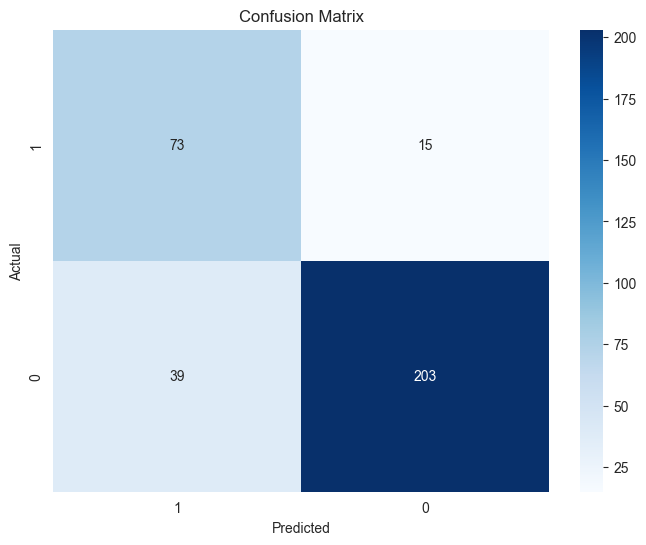

In [18]:
# Dự đoán


# Tính ma trận nhầm lẫn
cm = confusion_matrix(y_test, stacked_pred,labels=[1,0])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=[1,0], yticklabels=[1,0])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Kết luận:
- Nhóm xây dựng một mạng Netual network ứng dụng kỹ thuật trong học sâu như callbacks, đánh trọng số,.... Nhưng không khắc phục được tình trạng (imbalanced variable).

In [19]:
def check_result(prediction):
    if isinstance(prediction, (np.ndarray, pd.Series)):
        prediction = prediction.item()  # Hoặc sử dụng prediction[0] hoặc prediction.iloc[0]
    if prediction==1:
        return "Y"
    else:
        return "N"

In [20]:
hopdonggianlan = 0

def check_output(y_test,stacked_pred):
    solandung = 0
    hopdonggianlan=0
    y_test=np.array(y_test)
    for i in range(len(y_test)):
        if y_test[i]==stacked_pred[i]:
            solandung+=1
            if y_test[i]==1:
                hopdonggianlan+=1
                
    return solandung,hopdonggianlan
check_output(y_test,stacked_pred)            
solandung=check_output(y_test,stacked_pred)[0]
hopdonggianlan=check_output(y_test,stacked_pred)[1]


In [21]:
print(f"Số lần dự đoán đúng: {solandung} chiếm khoảng {(solandung/len(x_test))*100}% tổng lần dự đoán")
print(f"Số hợp đồng gian lận trong lần kiểm tra: {hopdonggianlan} chiếm khoảng {(hopdonggianlan/len(y_test[y_test['fraud_reported']==1]))*100}% so với thực tế")


Số lần dự đoán đúng: 276 chiếm khoảng 83.63636363636363% tổng lần dự đoán
Số hợp đồng gian lận trong lần kiểm tra: 73 chiếm khoảng 82.95454545454545% so với thực tế


* Ta có thể thấy trong tất cả các lần dự đoán, mô hình đều dự đoán 'N'(lớp 0). Đó là lí do tại sao chỉ số 'accuracy'lại cao như vậy ( vốn tập dữ liệu bị mất cân bằng lớp lớp 0 gấp 3 lần lớp 1)

#### => Kết luận: Ta không dựa vào chỉ số 'accuracy' để đánh giá các mô hình.